import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pickle
from hmmlearn.hmm import GaussianHMM
from scipy.spatial.distance import cdist
import pandas as pd
from scipy.integrate import cumulative_simpson as cum_simps
from scipy.integrate import cumulative_trapezoid as cum_trapz


Creating the MAP

In [876]:
#Defining function
def create_map(nodes, edges):
    """
    Creates a graph from nodes and edges.
    """
    graph = nx.DiGraph()  # Create a directed graph
    #graph = nx.Graph()
    graph.add_nodes_from(nodes)  # Add nodes with positions
    graph.add_weighted_edges_from(edges)  # Add edges with weights
    return graph

# Function to visualize the graph
def visualize_map(graph, start_points, end_points):
    """
    Visualizes the map with start and end points highlighted.
    """
    pos = nx.get_node_attributes(graph, 'pos')  # Extract positions for plotting
    node_colors = [
        "green" if node in start_points else "red" if node in end_points else "skyblue"
        for node in graph.nodes
    ]

    # Draw the graph
    nx.draw(graph, pos, with_labels=True, node_size=700, node_color=node_colors)
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=nx.get_edge_attributes(graph, "weight"))
    plt.title("Programmatically Created Map")
    plt.show()

# Function to save the map
def save_map(graph, filename="map_data.pkl"):
    """
    Saves the graph and metadata to a file.
    """
    data = {
        "nodes": list(graph.nodes(data=True)),
        "edges": list(graph.edges(data=True)),
        "start_points": start_points,
        "end_points": end_points
    }
    with open(filename, 'wb') as f:
        pickle.dump(data, f)
    print(f"Map saved to {filename}.")

def generate_imu_data(graph, path, n_steps, noise_std):
    """
    Generates synthetic IMU data based on a path from a NetworkX graph.

    Parameters:
        graph (nx.Graph): The NetworkX graph containing node positions.
        path (list): A list of node IDs representing the path.
        n_steps (int): Number of steps between each pair of nodes in the path.
        noise_std (float): Standard deviation of Gaussian noise to simulate IMU noise.

    Returns:
        np.ndarray: Array of points representing the noisy IMU path.
    """
    imu_data = []

    cumulative_error = np.array([0.0, 0.0])  # Initialize cumulative error (x, y)

    for i in range(len(path) - 1):

        start_node = path[i]
        end_node = path[i + 1]

        # Get positions of the start and end nodes
        start_pos = np.array(graph.nodes[start_node]['pos'])
        end_pos = np.array(graph.nodes[end_node]['pos'])

        # Interpolate points between nodes
        steps = np.linspace(start_pos, end_pos, n_steps, endpoint=False)

        # Add Gaussian noise to simulate IMU noise
        noisy_steps = steps + np.random.normal(0, noise_std, steps.shape)
        imu_data.extend(noisy_steps)

    # Add the final node position with noise
    final_pos = np.array(graph.nodes[path[-1]]['pos'])
    final_pos_noisy = final_pos + np.random.normal(0, noise_std, final_pos.shape)
    imu_data.append(final_pos_noisy)

    return np.array(imu_data)

def generate_imu_data_cumulative(graph, path, n_steps, noise_std, drift_rate=0.01):
    """
    Generates synthetic IMU data with cumulative error based on a path from a NetworkX graph.

    Parameters:
        graph (nx.Graph): The NetworkX graph containing node positions.
        path (list): A list of node IDs representing the path.
        n_steps (int): Number of steps between each pair of nodes in the path.
        noise_std (float): Standard deviation of Gaussian noise to simulate IMU noise.
        drift_rate (float): Rate at which cumulative error drifts over time.

    Returns:
        np.ndarray: Array of points representing the noisy IMU path.
    """
    imu_data = []
    cumulative_error = np.array([0.0, 0.0])  # Initialize cumulative error (x, y)
    bias = np.random.normal(0, 0.01)
    
    for i in range(len(path) - 1):
        start_node = path[i]
        end_node = path[i + 1]

        # Get positions of the start and end nodes
        start_pos = np.array(graph.nodes[start_node]['pos'])
        end_pos = np.array(graph.nodes[end_node]['pos'])

        # Interpolate points between nodes
        steps = np.linspace(start_pos, end_pos, n_steps, endpoint=False)

        # Add Gaussian noise and cumulative error
        for step in steps:
            noise = np.random.normal(bias, noise_std, step.shape)
            cumulative_error += drift_rate * noise  # Drift amplifies cumulative error
            noisy_step = step + cumulative_error
            imu_data.append(noisy_step)

    # Add the final node position with cumulative error
    final_pos = np.array(graph.nodes[path[-1]]['pos'])
    final_pos_noisy = final_pos + cumulative_error
    imu_data.append(final_pos_noisy)

    return np.array(imu_data)

def visualize_path_on_empty(path):

    # Extract positions for the path
    path_x, path_y = path[:, 0], path[:, 1]

    # Plot the path
    plt.plot(path_x, path_y, c='green', label="Path", linewidth=2, zorder=6)

    # Add legend
    plt.legend()
    plt.title("Path on empty background")
    plt.show()

def visualize_path_on_map(graph, path):
    """
    Visualizes a given path on the map using the provided visualize_map function.

    Parameters:
    - graph: NetworkX graph representing the map.
    - path: List of node IDs representing the path.
    - visualize_map_fn: Function to visualize the map (e.g., visualize_map).
    """
    pos = nx.get_node_attributes(graph, 'pos')  # Extract positions for plotting
    

    # Draw the graph
    nx.draw(graph, pos, with_labels=True, node_size=700)
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=nx.get_edge_attributes(graph, "weight"))

    # Extract positions for the path
    path_x, path_y = path[:, 0], path[:, 1]

    # Plot the path
    plt.plot(path_x, path_y, c='green', label="Path", linewidth=2, zorder=6)

    # Add legend
    plt.legend()
    plt.title("Path on the Map")
    plt.show()



In [877]:
#defining the map

# Define the nodes with positions
# Format: (node_id, {"pos": (x, y)})
nodes = [
    (1, {"pos": (0, 0)}),  # Start point
    (2, {"pos": (0, -1)}),
    (3, {"pos": (1, 0)}),
    (4, {"pos": (1, -1)}),   # End point
    (5, {"pos": (2, 0)}),   # End point
    (6, {"pos": (2, -1)}),   # End point
    (7, {"pos": (3, -1)}),   # End point
    (8, {"pos": (3, -2)}),   # End point
    (9, {"pos": (4, -2)}),   # End point
    (10, {"pos": (3, -3)})   # End point
]

# Define the edges with weights
# Format: (from_node, to_node, weight)
edges = [ #(frome_node, to_node, weight)
    (1, 2, 1),  # Weight is the distance between nodes
    (2, 4, 1),
    (3, 4, 1),
    (4, 6, 1),
    (5, 6, 1),
    (6, 7, 1),
    (7, 8, 1),
    (9, 8, 1),
    (8, 10, 1),
]

# Define start and end points
start_points = [1,3,5,9]  # Node IDs for start points
end_points = [10]    # Node IDs for end points

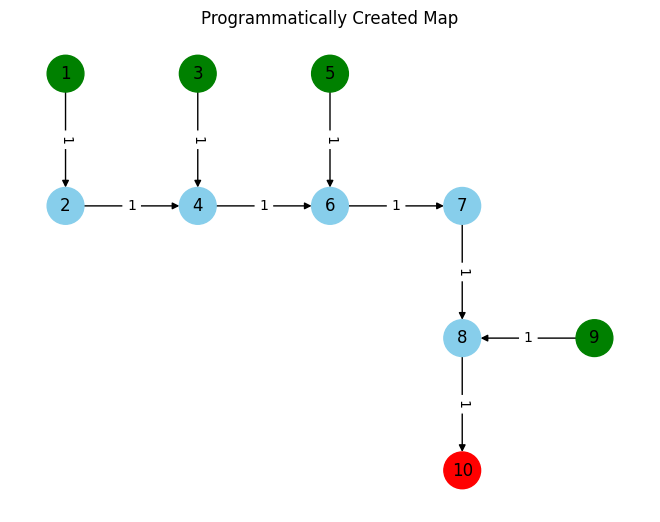

In [878]:
graph = create_map(nodes, edges)  # Create the graph
visualize_map(graph, start_points, end_points)  # Visualize the graph

In [879]:
path_nodes = [1, 2, 4,6,7,8,10]
#imu_data = generate_imu_data(graph, path_nodes, n_steps=100, noise_std=0.01)
imu_data = generate_imu_data_cumulative(graph, path_nodes, n_steps=100, noise_std=0.1)
print("IMU Data:", imu_data)

IMU Data: [[-3.65551948e-04  4.09363448e-05]
 [ 2.09580141e-04 -1.10845917e-02]
 [-4.10732390e-04 -2.05677246e-02]
 ...
 [ 2.88707148e+00 -3.07554876e+00]
 [ 2.88627274e+00 -3.08381164e+00]
 [ 2.88627274e+00 -3.09381164e+00]]


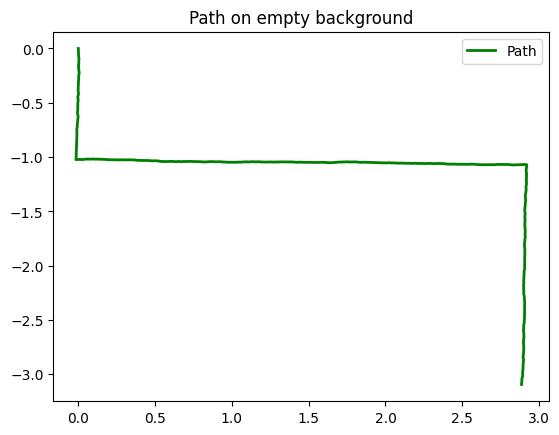

In [880]:
visualize_path_on_empty(imu_data)

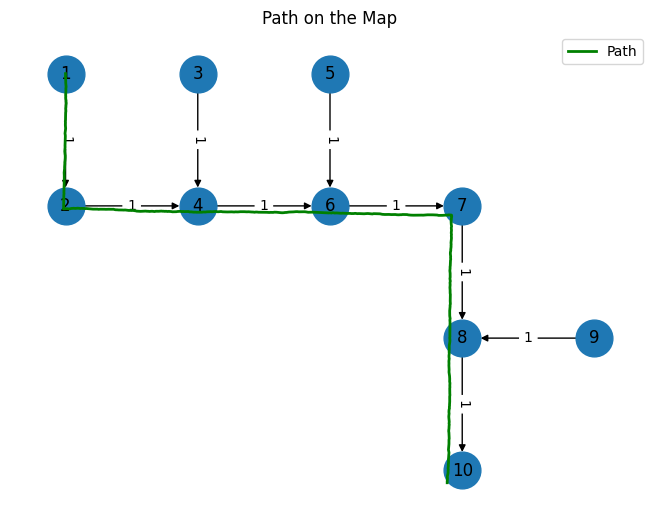

In [881]:
visualize_path_on_map(graph, imu_data)

In [882]:
#imu_accel = pd.read_csv('IMU_test_circular.txt', header=None)
imu_data = pd.read_csv('test_path1_tracing_run_1.csv', header=0)

#imu_accel.columns = ["a_x", "a_y", "a_z", 'timestamp']

In [883]:
imu_data.head()

,a_x,a_y,a_z,w_x,w_y,w_z,timestamp
0,0.00,0.0,1.0,0.57,-1.17,-0.08,8432
1,0.00,0.0,1.0,0.57,-1.17,-0.06,8435
2,0.01,0.0,1.0,0.59,-1.10,-0.08,8438
3,0.01,0.0,1.0,0.59,-1.06,-0.09,8442
4,0.01,0.0,1.0,0.60,-1.01,-0.11,8445


In [884]:

#turn all units to SI

def raw_to_si(raw_val, lsb_per_g = 16384):
    g_to_si = 9.81
    return raw_val/lsb_per_g * g_to_si
    
def g_to_si(g):
    return g*9.81

def millis_to_sec(milis):
    return milis/1000

print("imu_data columns:", imu_data.columns)
if 'timestamp' not in imu_data.columns:
    print("'timestamp' column is missing!")


# Convert acceleration values to SI
imu_data[['a_x', 'a_y', 'a_z']] = imu_data[['a_x', 'a_y', 'a_z']].apply(lambda col: col.apply(g_to_si))

# Convert timestamp to seconds
imu_data['timestamp'] = imu_data['timestamp'].apply(millis_to_sec)


imu_data columns: Index(['a_x', 'a_y', 'a_z', 'w_x', 'w_y', 'w_z', 'timestamp'], dtype='object')


In [885]:
imu_data.head()

,a_x,a_y,a_z,w_x,w_y,w_z,timestamp
0,0.0000,0.0,9.81,0.57,-1.17,-0.08,8.432
1,0.0000,0.0,9.81,0.57,-1.17,-0.06,8.435
2,0.0981,0.0,9.81,0.59,-1.10,-0.08,8.438
3,0.0981,0.0,9.81,0.59,-1.06,-0.09,8.442
4,0.0981,0.0,9.81,0.60,-1.01,-0.11,8.445


In [886]:
pos_data = pd.DataFrame()
pos_data['a_x'] = imu_data['a_x']
pos_data['a_y'] = imu_data['a_y']
pos_data['timestamp'] = imu_data['timestamp']


pos_data['v_x'] = 0
pos_data['v_y'] = 0
pos_data['x'] = 0 #set this to the known start position
pos_data['y'] = 0 #set this to the known start position

# Specify the desired column order
desired_order = ['x', 'y', 'v_x', 'v_y', 'a_x', 'a_y', 'timestamp']

# Reorder the columns
pos_data = pos_data[desired_order]

In [887]:
#run this if you want to exclude first 30s where big error has been identified
#pos_data = pos_data[pos_data['timestamp'] > 30]
#pos_data = pos_data.reset_index(drop=True)

In [888]:
pos_data.columns

Index(['x', 'y', 'v_x', 'v_y', 'a_x', 'a_y', 'timestamp'], dtype='object')

In [889]:
pos_data.head()

,x,y,v_x,v_y,a_x,a_y,timestamp
0,0,0,0,0,0.0000,0.0,8.432
1,0,0,0,0,0.0000,0.0,8.435
2,0,0,0,0,0.0981,0.0,8.438
3,0,0,0,0,0.0981,0.0,8.442
4,0,0,0,0,0.0981,0.0,8.445


In [890]:
pos_data.tail()

,x,y,v_x,v_y,a_x,a_y,timestamp
9894,0,0,0,0,0.0981,0.0981,42.588
9895,0,0,0,0,0.0981,0.0000,42.591
9896,0,0,0,0,0.0981,0.0000,42.594
9897,0,0,0,0,0.0981,0.0000,42.598
9898,0,0,0,0,0.0981,0.0000,42.601


In [891]:
pos_data_simps = pos_data
pos_data_trapz = pos_data

#integrating with trapezoidal rule
pos_data_trapz['v_x'] = np.concatenate([[0], cum_trapz(y = pos_data_simps['a_x'], x = pos_data_simps['timestamp'])])
pos_data_trapz['v_y'] = np.concatenate([[0], cum_trapz(y = pos_data_simps['a_y'], x = pos_data_simps['timestamp'])])

pos_data_trapz['x'] = np.concatenate([[0], cum_trapz(y = pos_data_simps['v_x'], x = pos_data_simps['timestamp'])])
pos_data_trapz['y'] = np.concatenate([[0], cum_trapz(y = pos_data_simps['v_y'], x = pos_data_simps['timestamp'])])

# integrating with simpsons rule
pos_data_simps['v_x'] = np.concatenate([[0], cum_simps(y = pos_data_simps['a_x'], x = pos_data_simps['timestamp'])])
pos_data_simps['v_y'] = np.concatenate([[0], cum_simps(y = pos_data_simps['a_y'], x = pos_data_simps['timestamp'])])

pos_data_simps['x'] = np.concatenate([[0], cum_simps(y = pos_data_simps['v_x'], x = pos_data_simps['timestamp'])])
pos_data_simps['y'] = np.concatenate([[0], cum_simps(y = pos_data_simps['v_y'], x = pos_data_simps['timestamp'])])


In [892]:
pos_data_simps.head()

,x,y,v_x,v_y,a_x,a_y,timestamp
0,0.000000e+00,0.0,0.000000,0.0,0.0000,0.0,8.432
1,-7.357500e-08,0.0,-0.000025,0.0,0.0000,0.0,8.435
2,0.000000e+00,0.0,0.000098,0.0,0.0981,0.0,8.438
3,1.177200e-06,0.0,0.000490,0.0,0.0981,0.0,8.442
4,3.090150e-06,0.0,0.000785,0.0,0.0981,0.0,8.445


In [893]:
pos_data_trapz.head()

,x,y,v_x,v_y,a_x,a_y,timestamp
0,0.000000e+00,0.0,0.000000,0.0,0.0000,0.0,8.432
1,-7.357500e-08,0.0,-0.000025,0.0,0.0000,0.0,8.435
2,0.000000e+00,0.0,0.000098,0.0,0.0981,0.0,8.438
3,1.177200e-06,0.0,0.000490,0.0,0.0981,0.0,8.442
4,3.090150e-06,0.0,0.000785,0.0,0.0981,0.0,8.445


In [894]:
for i in range(1,len(pos_data)):
    dt = pos_data['timestamp'][i] - pos_data['timestamp'][i-1]

    # integrate velocity
    pos_data.loc[i, 'v_x'] = pos_data.loc[i-1, 'v_x'] + pos_data.loc[i, 'a_x'] * dt
    pos_data.loc[i, 'v_y'] = pos_data.loc[i-1, 'v_y'] + pos_data.loc[i, 'a_y'] * dt
    
    # integrate position
    pos_data.loc[i, 'x'] = pos_data.loc[i-1, 'x'] + pos_data.loc[i, 'v_x'] * dt
    pos_data.loc[i, 'y'] = pos_data.loc[i-1, 'y'] + pos_data.loc[i, 'v_y'] * dt

pos_data.tail()


,x,y,v_x,v_y,a_x,a_y,timestamp
9894,2.528690,163.144812,-1.320524,9.850613,0.0981,0.0981,42.588
9895,2.524729,163.174364,-1.320230,9.850613,0.0981,0.0000,42.591
9896,2.520769,163.203916,-1.319936,9.850613,0.0981,0.0000,42.594
9897,2.515491,163.243318,-1.319543,9.850613,0.0981,0.0000,42.598
9898,2.511533,163.272870,-1.319249,9.850613,0.0981,0.0000,42.601


In [895]:
pos_data.columns

Index(['x', 'y', 'v_x', 'v_y', 'a_x', 'a_y', 'timestamp'], dtype='object')

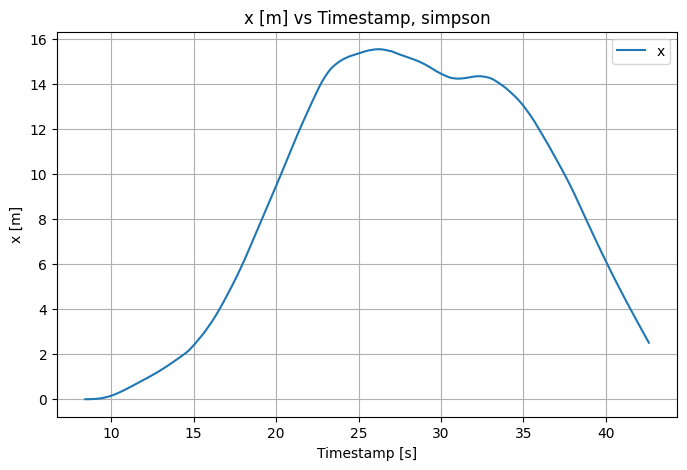

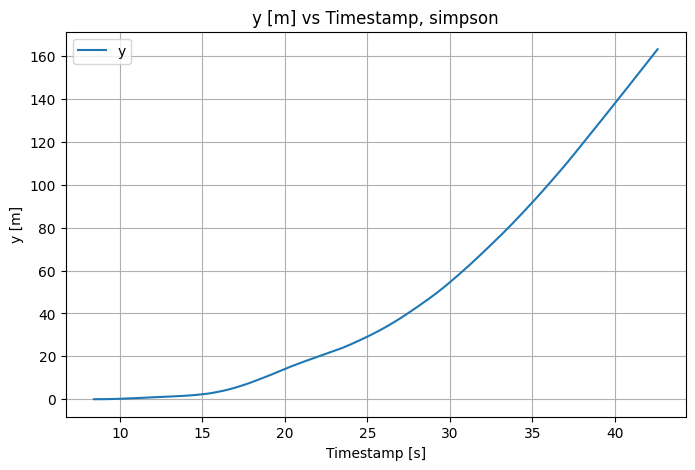

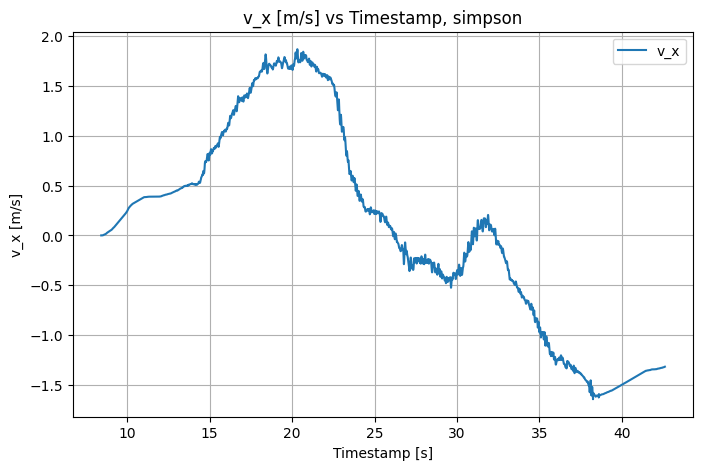

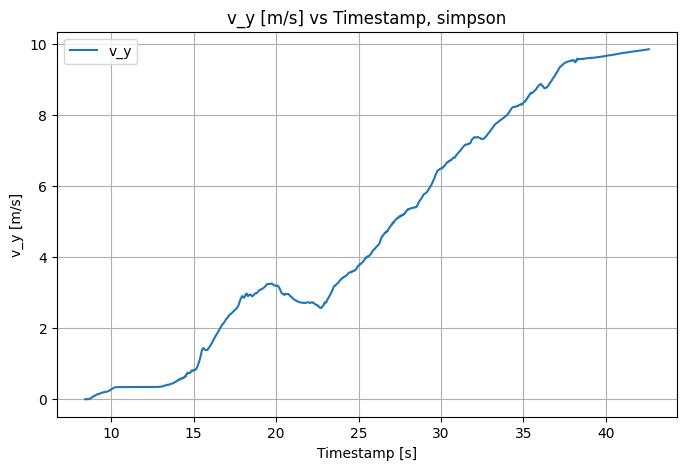

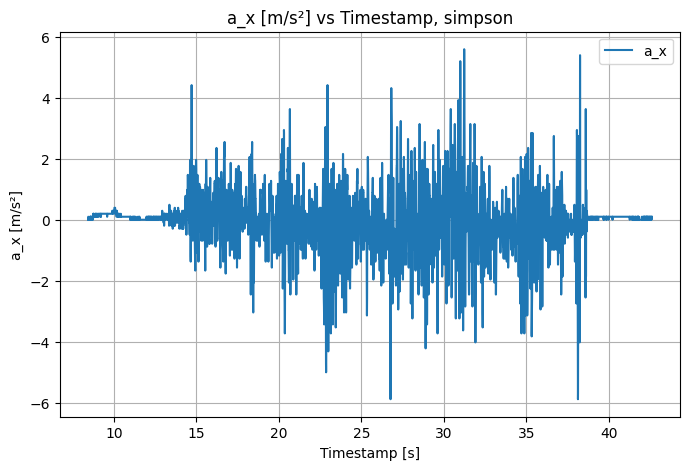

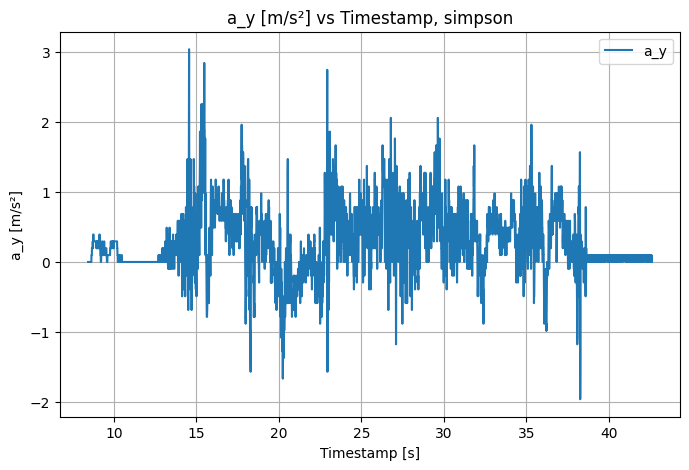

In [896]:
columns_to_plot = ['x', 'y', 'v_x', 'v_y', 'a_x', 'a_y']

# Define a dictionary to map columns to their corresponding units
units = {
    'x': '[m]',       # Position in meters
    'y': '[m]',       # Position in meters
    'v_x': '[m/s]',   # Velocity in meters per second
    'v_y': '[m/s]',   # Velocity in meters per second
    'a_x': '[m/s²]',  # Acceleration in meters per second squared
    'a_y': '[m/s²]'   # Acceleration in meters per second squared
}

# Plot each column against timestamp
for column in columns_to_plot:
    plt.figure(figsize=(8, 5))  # Set figure size
    plt.plot(pos_data_simps['timestamp'], pos_data_simps[column], label=column)
    plt.xlabel('Timestamp [s]')  # Label for x-axis
    plt.ylabel(f'{column} {units[column]}')  # Add units to y-axis label
    plt.title(f'{column} {units[column]} vs Timestamp, simpson')  # Add units to the title
    plt.legend()  # Show legend
    plt.grid(True)  # Add a grid for better visualization
    plt.show()  # Display the plot


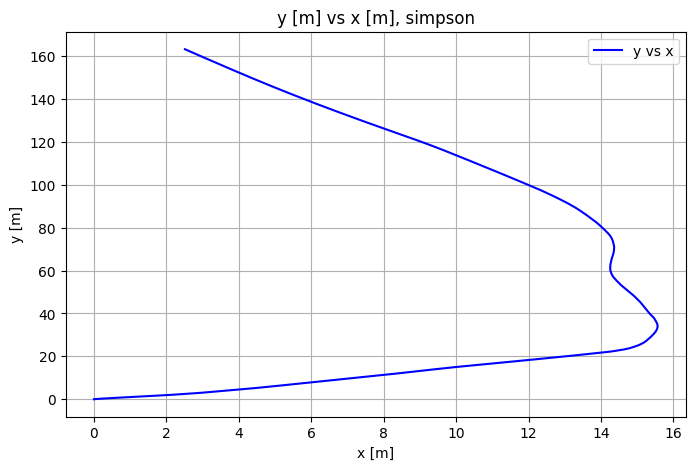

In [897]:
# Plot y against x
plt.figure(figsize=(8, 5))  # Set figure size
plt.plot(pos_data_simps['x'], pos_data_simps['y'], label='y vs x', color='blue')  # Plot y against x
plt.xlabel('x [m]')  # Label for x-axis with units
plt.ylabel('y [m]')  # Label for y-axis with units
plt.title('y [m] vs x [m], simpson')  # Title of the plot
plt.legend()  # Show legend
plt.grid(True)  # Add a grid for better visualization
plt.show()  # Display the plot

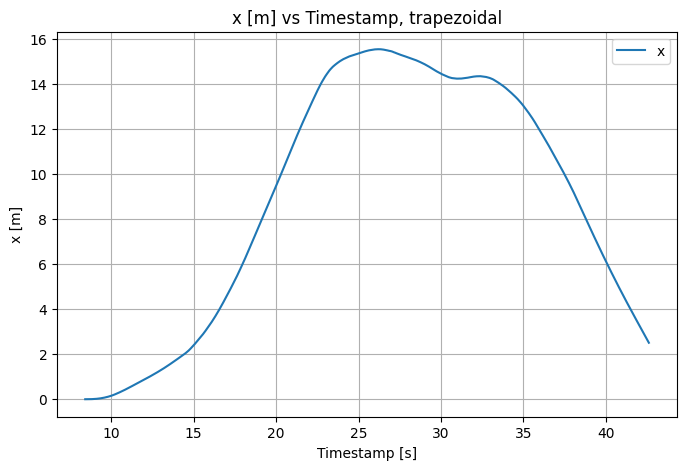

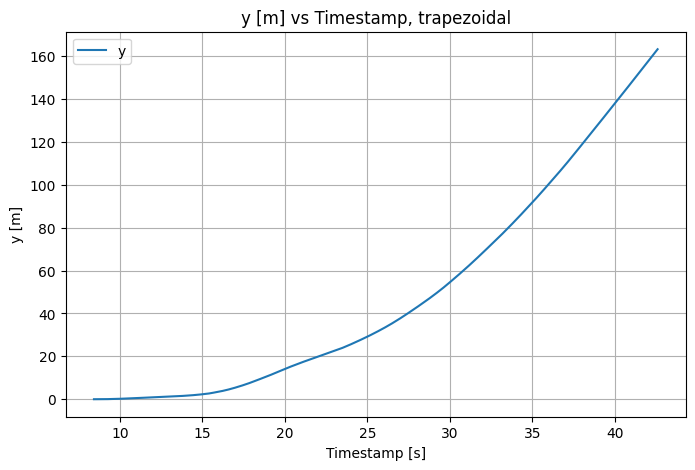

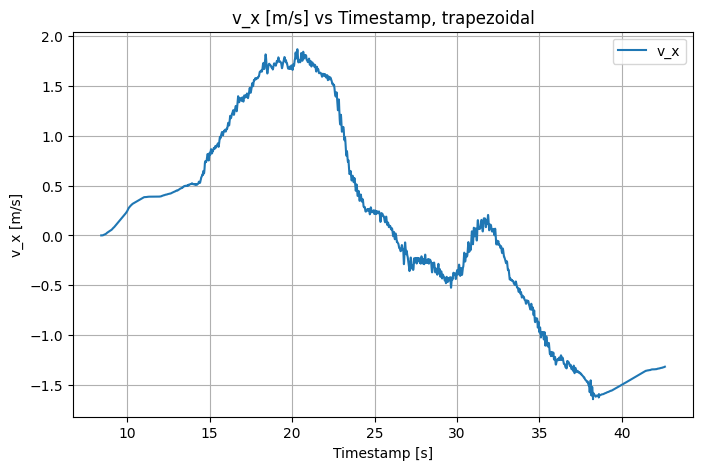

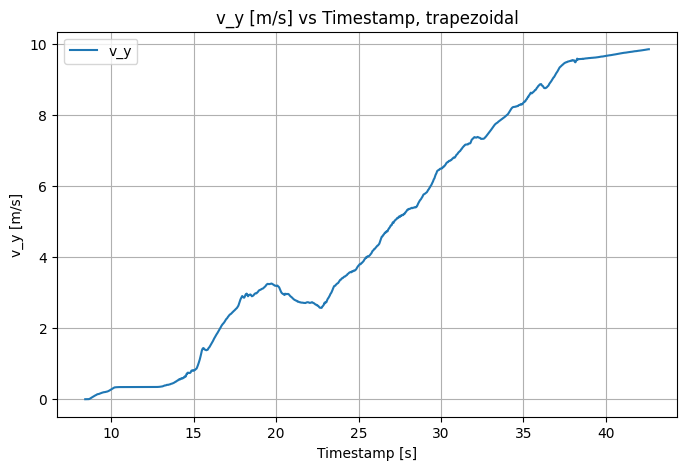

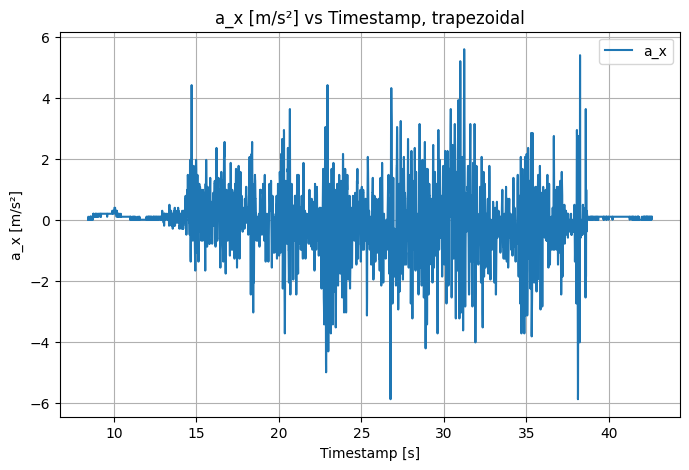

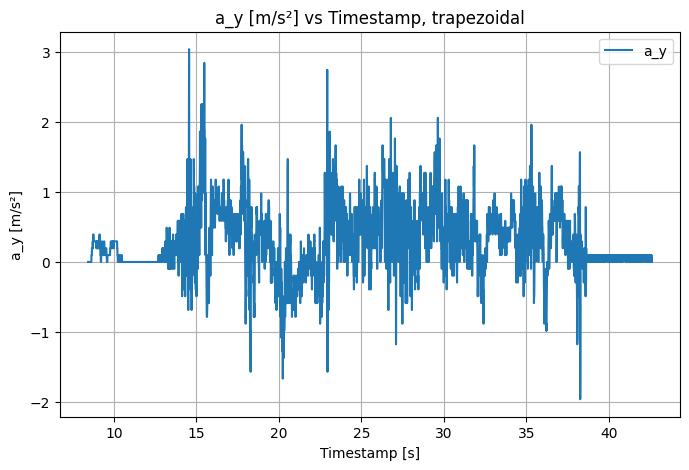

In [898]:
columns_to_plot = ['x', 'y', 'v_x', 'v_y', 'a_x', 'a_y']

# Define a dictionary to map columns to their corresponding units
units = {
    'x': '[m]',       # Position in meters
    'y': '[m]',       # Position in meters
    'v_x': '[m/s]',   # Velocity in meters per second
    'v_y': '[m/s]',   # Velocity in meters per second
    'a_x': '[m/s²]',  # Acceleration in meters per second squared
    'a_y': '[m/s²]'   # Acceleration in meters per second squared
}

# Plot each column against timestamp
for column in columns_to_plot:
    plt.figure(figsize=(8, 5))  # Set figure size
    plt.plot(pos_data_trapz['timestamp'], pos_data_trapz[column], label=column)
    plt.xlabel('Timestamp [s]')  # Label for x-axis
    plt.ylabel(f'{column} {units[column]}')  # Add units to y-axis label
    plt.title(f'{column} {units[column]} vs Timestamp, trapezoidal')  # Add units to the title
    plt.legend()  # Show legend
    plt.grid(True)  # Add a grid for better visualization
    plt.show()  # Display the plot

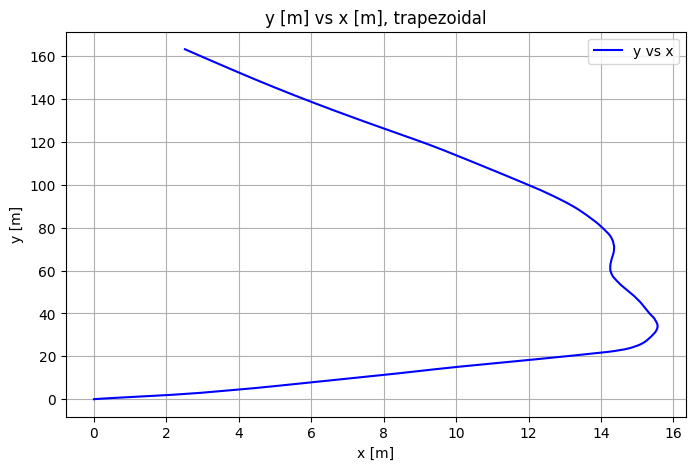

In [899]:
# Plot y against x
plt.figure(figsize=(8, 5))  # Set figure size
plt.plot(pos_data_simps['x'], pos_data_simps['y'], label='y vs x', color='blue')  # Plot y against x
plt.xlabel('x [m]')  # Label for x-axis with units
plt.ylabel('y [m]')  # Label for y-axis with units
plt.title('y [m] vs x [m], trapezoidal')  # Title of the plot
plt.legend()  # Show legend
plt.grid(True)  # Add a grid for better visualization
plt.show()  # Display the plot

In [900]:
rot_data = pd.DataFrame()

rot_data['w_x'] = imu_data['w_x']
rot_data['w_y'] = imu_data['w_y']
rot_data['w_z'] = imu_data['w_z']
rot_data['timestamp'] = imu_data['timestamp']

rot_data.head()



,w_x,w_y,w_z,timestamp
0,0.57,-1.17,-0.08,8.432
1,0.57,-1.17,-0.06,8.435
2,0.59,-1.10,-0.08,8.438
3,0.59,-1.06,-0.09,8.442
4,0.60,-1.01,-0.11,8.445


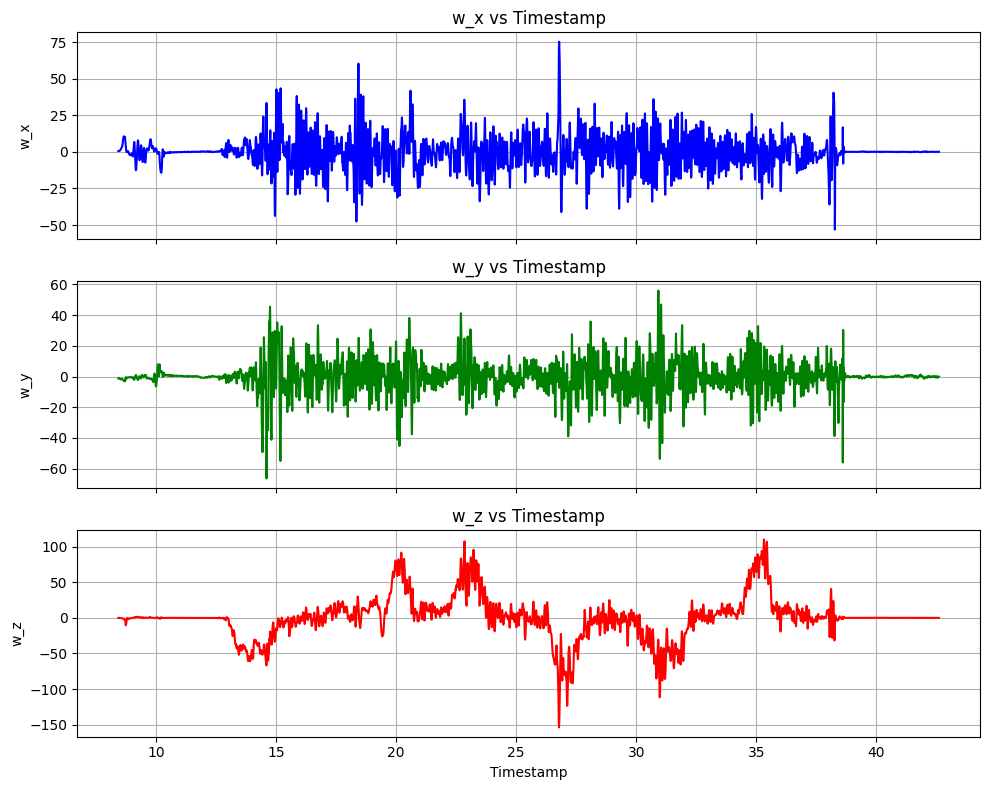

In [901]:

# Create a figure with multiple subplots (one for each column)
fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

# Plot each column against the timestamp on a separate subplot
axs[0].plot(rot_data['timestamp'], rot_data['w_x'], color='b')
axs[0].set_ylabel('w_x')
axs[0].set_title('w_x vs Timestamp')
axs[0].grid(True)

axs[1].plot(rot_data['timestamp'], rot_data['w_y'], color='g')
axs[1].set_ylabel('w_y')
axs[1].set_title('w_y vs Timestamp')
axs[1].grid(True)

axs[2].plot(rot_data['timestamp'], rot_data['w_z'], color='r')
axs[2].set_xlabel('Timestamp')
axs[2].set_ylabel('w_z')
axs[2].set_title('w_z vs Timestamp')
axs[2].grid(True)

# Adjust layout to prevent overlap of titles and labels
plt.tight_layout()

# Display the plots
plt.show()


In [902]:
# integrating with simpsons rule
rot_data['theta_x'] = np.concatenate([[0], cum_simps(y = rot_data['w_x'], x = pos_data_simps['timestamp'])])
rot_data['theta_y'] = np.concatenate([[0], cum_simps(y = rot_data['w_y'], x = pos_data_simps['timestamp'])])
rot_data['theta_z'] = np.concatenate([[0], cum_simps(y = rot_data['w_z'], x = pos_data_simps['timestamp'])])


In [903]:
rot_data.head()

,w_x,w_y,w_z,timestamp,theta_x,theta_y,theta_z
0,0.57,-1.17,-0.08,8.432,0.000000,0.000000,0.000000
1,0.57,-1.17,-0.06,8.435,0.001705,-0.003528,-0.000200
2,0.59,-1.10,-0.08,8.438,0.003440,-0.006950,-0.000400
3,0.59,-1.06,-0.09,8.442,0.005795,-0.011280,-0.000734
4,0.60,-1.01,-0.11,8.445,0.007578,-0.014389,-0.001031


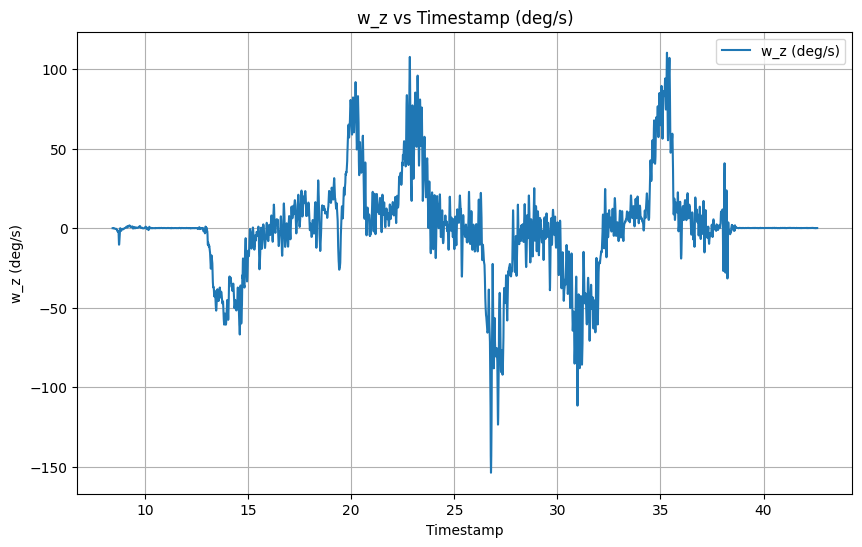

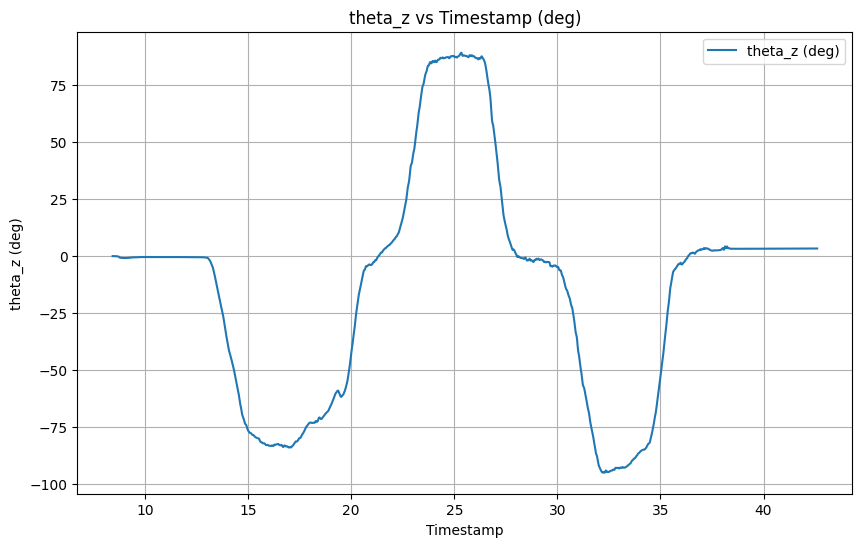

In [904]:
#columns_to_plot = ['w_x', 'w_y', 'w_z', 'theta_x', 'theta_y', 'theta_z']
columns_to_plot = ['w_z', 'theta_z']
units = {
    'w_x': 'deg/s',
    'w_y': 'deg/s',
    'w_z': 'deg/s',
    'theta_x': 'deg',
    'theta_y': 'deg',
    'theta_z': 'deg'
}

# Create individual plots with units in labels and titles
for column in columns_to_plot:
    plt.figure(figsize=(10, 6))
    plt.plot(rot_data['timestamp'], rot_data[column], label=f'{column} ({units[column]})')
    plt.xlabel('Timestamp')
    plt.ylabel(f'{column} ({units[column]})')
    plt.title(f'{column} vs Timestamp ({units[column]})')
    plt.legend()
    plt.grid()
    plt.show()

In [905]:
print(max(rot_data['theta_z']))
print(min(rot_data['theta_z']))

89.2555592777785
-95.06293741666603


In [906]:
rot_data.dtypes

w_x          float64
w_y          float64
w_z          float64
timestamp    float64
theta_x      float64
theta_y      float64
theta_z      float64
dtype: object

left_turn array is not empty
right_turn array is not empty


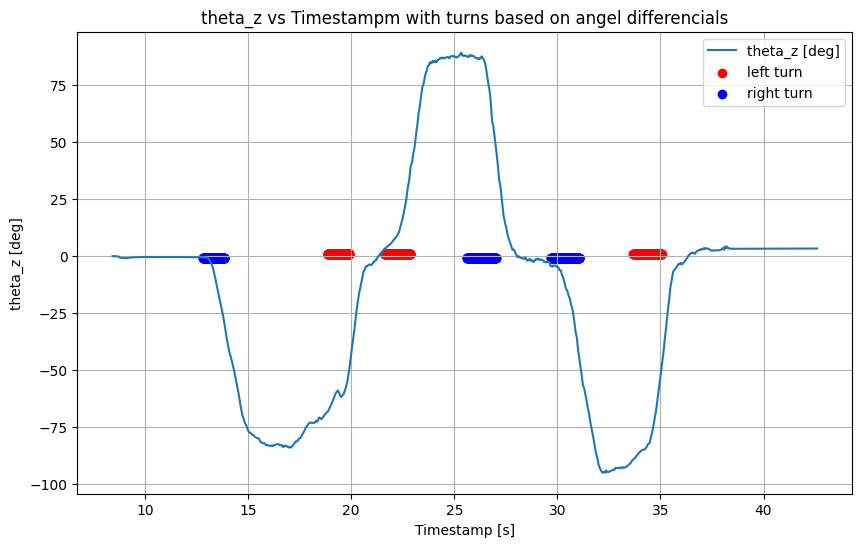

In [ ]:
def calculate_turns(data, time_window=3):
    rolling_diff = []
    for i in range(len(data)):
        # Find the start of the time window
        current_time = data['timestamp'].iloc[i]
        window_end = current_time + time_window
        # Filter rows within the time window
        window_data = data[(data['timestamp'] >= current_time) & (data['timestamp'] <= window_end)]
        # Calculate the difference between the latest and earliest value
        if len(window_data) > 1:  # Ensure there are at least two points to calculate a difference
            diff = window_data['theta_z'].iloc[-1] - window_data['theta_z'].iloc[0]
        else:
            diff = 0  # Default value if no data or single point in window
        rolling_diff.append(diff)
    return rolling_diff

# Calculate rolling differences
rot_data['rolling_diff'] = calculate_turns(rot_data, time_window = 1.5)

# Define turn_right and turn_left based on the rolling differences
rot_data['turn_right'] = rot_data['rolling_diff'] < -50
rot_data['turn_left'] = rot_data['rolling_diff'] > 50

# Drop the rolling_diff column if not needed
rot_data.drop(columns=['rolling_diff'], inplace=True)

# Display the updated DataFrame
rot_data.head()

# Initialize arrays
left_turn = []
right_turn = []

# Iterate through the DataFrame rows
for _, row in rot_data.iterrows():
    if row['turn_left']:
        left_turn.append([row['timestamp'], 1])  # Append [timestamp, 0] for left turn
    if row['turn_right']:
        right_turn.append([row['timestamp'], -1])  # Append [timestamp, 0] for right turn

# Convert to NumPy arrays (optional)
left_turn = np.array(left_turn)
right_turn = np.array(right_turn)

if left_turn.size == 0:
    print("left_turn array is empty")
else:
    print("left_turn array is not empty")

if right_turn.size == 0:
    print("right_turn array is empty")
else:
    print("right_turn array is not empty")


plt.figure(figsize=(10, 6))
plt.plot(rot_data['timestamp'], rot_data['theta_z'], label=f'theta_z [deg]')
plt.xlabel('Timestamp [s]')
plt.ylabel(f'theta_z [deg]')
plt.title(f'theta_z vs Timestampm with turns based on angel differencials')
plt.scatter(left_turn[:,0], left_turn[:,1], label = 'left turn', color = 'r')
plt.scatter(right_turn[:,0], right_turn[:,1], label = 'right turn', color = 'b')
plt.legend()
plt.grid()
plt.show()



left_turn array is not empty
right_turn array is not empty


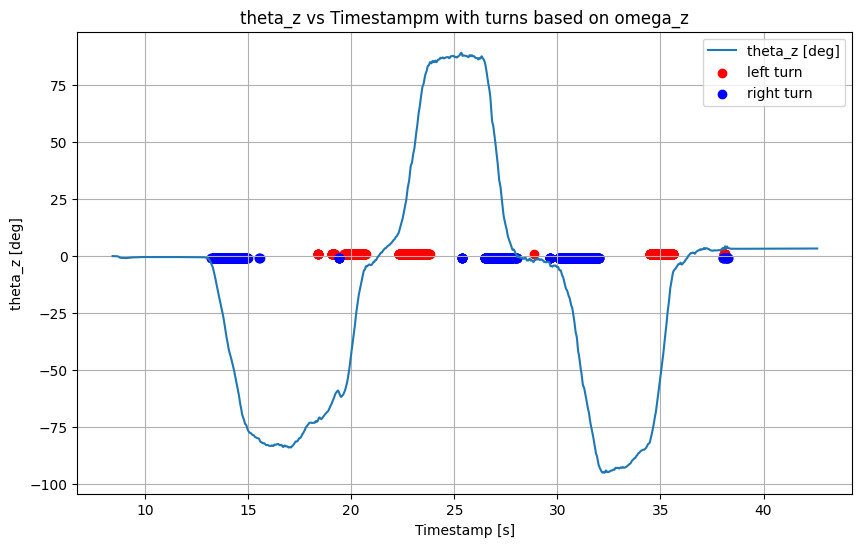

In [910]:
# Define turn_right and turn_left based on the angular speed
rot_data['turn_right'] = rot_data['w_z'] < -25
rot_data['turn_left'] = rot_data['w_z'] > 25


# Initialize arrays
left_turn = []
right_turn = []

# Iterate through the DataFrame rows
for _, row in rot_data.iterrows():
    if row['turn_left']:
        left_turn.append([row['timestamp'], 1])  # Append [timestamp, 0] for left turn
    if row['turn_right']:
        right_turn.append([row['timestamp'], -1])  # Append [timestamp, 0] for right turn

# Convert to NumPy arrays (optional)
left_turn = np.array(left_turn)
right_turn = np.array(right_turn)

if left_turn.size == 0:
    print("left_turn array is empty")
else:
    print("left_turn array is not empty")

if right_turn.size == 0:
    print("right_turn array is empty")
else:
    print("right_turn array is not empty")


plt.figure(figsize=(10, 6))
plt.plot(rot_data['timestamp'], rot_data['theta_z'], label=f'theta_z [deg]')
plt.xlabel('Timestamp [s]')
plt.ylabel(f'theta_z [deg]')
plt.title(f'theta_z vs Timestampm with turns based on omega_z')
plt.scatter(left_turn[:,0], left_turn[:,1], label = 'left turn', color = 'r')
plt.scatter(right_turn[:,0], right_turn[:,1], label = 'right turn', color = 'b')
plt.legend()
plt.grid()
plt.show()
